# Example using orographic precipitation model as a FastScape component

Import relevant libraries.

In [1]:
from fastscape.models import basic_model
from orographic_precipitation.fastscape_ext import precip_model
import xsimlab as xs
import xarray as xr
import numpy as np
%reload_ext xsimlab.ipython

Visualize processes in [basic FastScape model](https://fastscape.readthedocs.io/en/latest/models.html) with orographic precipitation component.

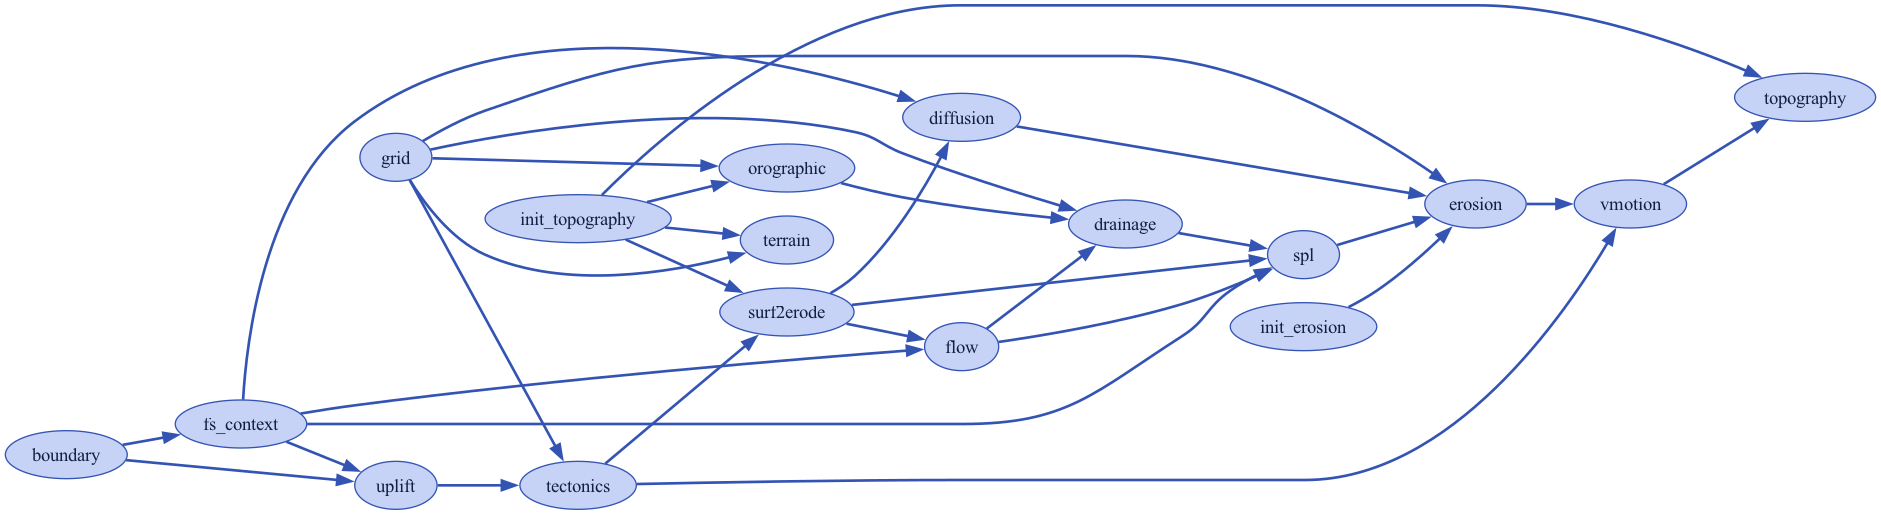

In [2]:
precip_model.visualize()

List of processes and inputs to the basic precipitation model.

In [3]:
precip_model

<xsimlab.Model (17 processes, 25 inputs)>
grid
    shape                  [in] ('shape_yx',) nb. of grid nodes in ...
    length                 [in] ('shape_yx',) total grid length in ...
boundary
    status                 [in] () or ('border',) node status at bo...
fs_context
uplift
    rate                   [in] () or ('y', 'x') uplift rate
tectonics
init_topography
    seed                   [in] random seed
surf2erode
init_erosion
diffusion
    diffusivity            [in] () or ('y', 'x') diffusivity (trans...
flow
orographic
    lapse_rate             [in] environmental lapse rate
    lapse_rate_m           [in] moist adiabatic lapse rate
    ref_density            [in] reference saturation water vapor de...
    latitude               [in] latitude
    precip_base            [in] () or ('y', 'x') background, non-or...
    rainfall_frequency  [inout] daily rainfall frequency
    wind_speed             [in] wind speed
    wind_dir               [in] wind direction (azimuth)
    c

Two dimensional background precipitation. The orographic precipitation model can also take single value or a value that changes through time.

In [4]:
precip_base_arr = np.ones([101, 201])
precip_base_arr=precip_base_arr*5
xr_2d = xr.DataArray(np.ones((101,201)), dims=['y','x'])
precip_base_xr=xr_2d*5

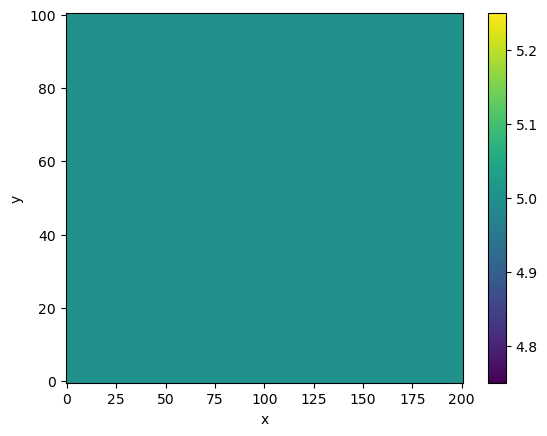

In [5]:
precip_base_xr.plot()

Setting up and computing a single [FastScape simulation](https://github.com/fastscape-lem/fastscape-demo).

In [10]:
ds_in = xs.create_setup(
    model=precip_model,
    clocks={'time':np.linspace(0,10e6,101)
    },
    input_vars={
        'grid__shape': [101, 201],
        'grid__length': [100e3, 200e3],
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': 5e-3,
        'spl__k_coef': 2.5e-5,
        'spl__area_exp': 0.4,
        'spl__slope_exp': 1.,
        'diffusion__diffusivity': 0.,
        'init_topography__seed': 1234,
        'orographic':{'rainfall_frequency':1, 
                         'latitude': 40, 
                         'precip_base': precip_base_xr,        
                         'wind_speed': 10,          
                         'wind_dir': 270,
         }
    },
    output_vars={
        'topography__elevation': 'time',
        'orographic__precip_rate':'time'
    }
)

/Users/acevedo/mambaforge/envs/orographic_precipitation_dev/lib/python3.10/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'time' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)


In [7]:
with precip_model, xs.monitoring.ProgressBar():
    ds_out = ds_in.xsimlab.run()

             0% | initialize 

/Users/acevedo/mambaforge/envs/orographic_precipitation_dev/lib/python3.10/site-packages/xsimlab/drivers.py:338: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for step, (_, ds_step) in enumerate(ds_gby_steps):


Plotting of the results using [xarray tools](https://docs.xarray.dev/en/stable/user-guide/plotting.html).

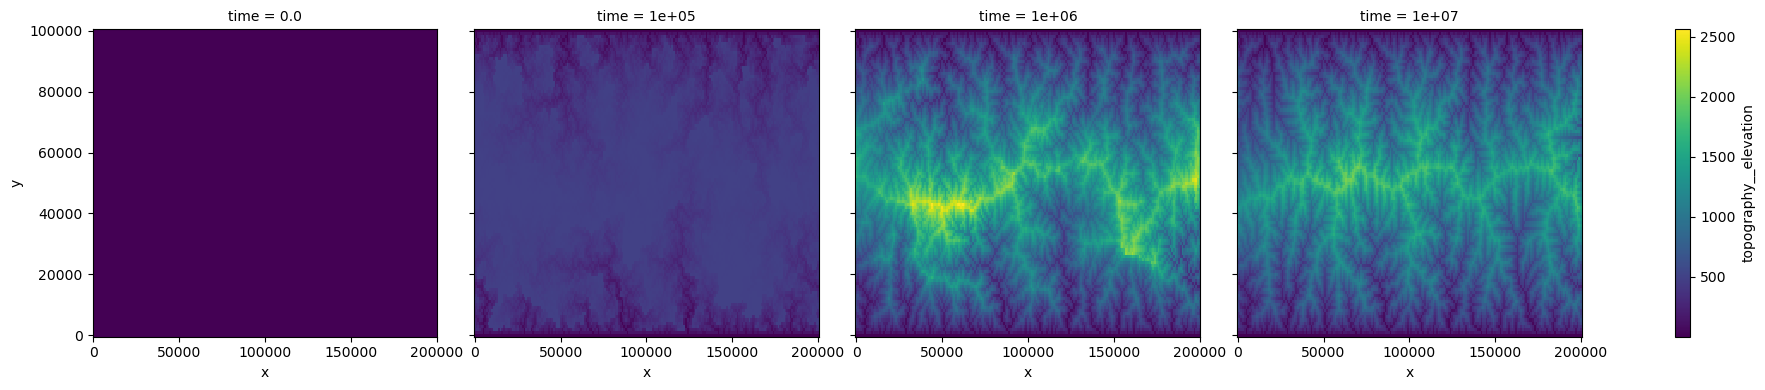

In [8]:
ds_out.topography__elevation.isel(time=[0,1,10,100]).plot(col='time',figsize=(20, 4))

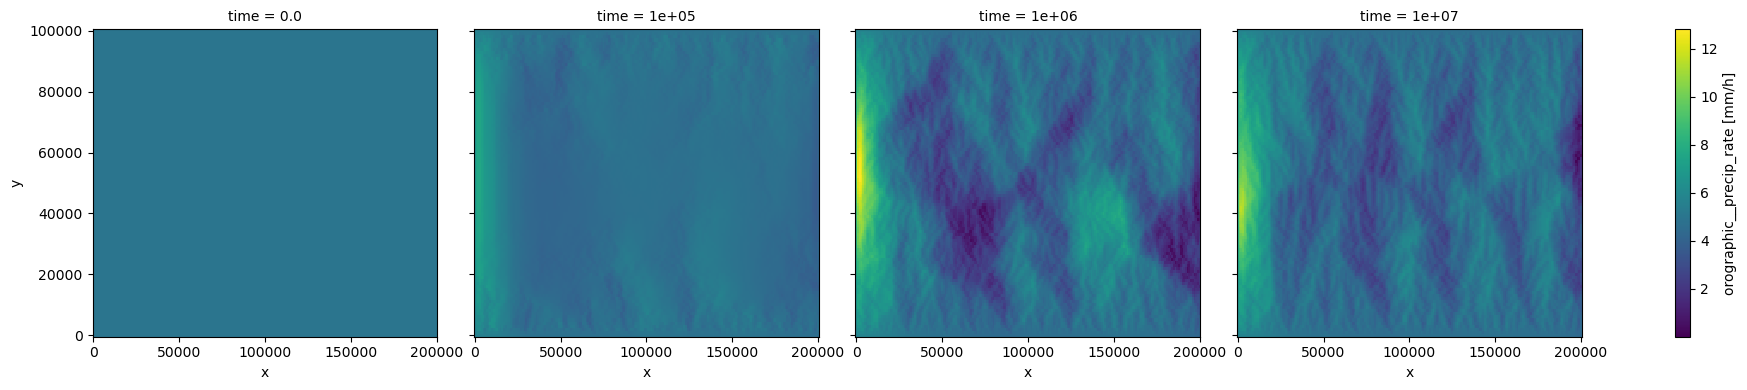

In [9]:
ds_out.orographic__precip_rate.isel(time=[0,1,10,100]).plot(col='time',figsize=(20, 4))